In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, precision_recall_curve, average_precision_score,
                             roc_curve, roc_auc_score)
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
Y_train = train['Exited']
X_train = train.drop(['Exited', 'id','CustomerId', 'Surname'], axis = 1)
test = test.drop([ 'id','CustomerId', 'Surname'], axis = 1)

In [ ]:
X_train.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [ ]:
test.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

Etude des données

In [ ]:
status_counts = train['Exited'].value_counts()

In [ ]:
status_counts

0    130113
1     34921
Name: Exited, dtype: int64

<ipython-input-58-3f75f79ccb00>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot( x = 'Exited', data = train, palette = 'Pastel1')


<Axes: xlabel='Exited', ylabel='count'>

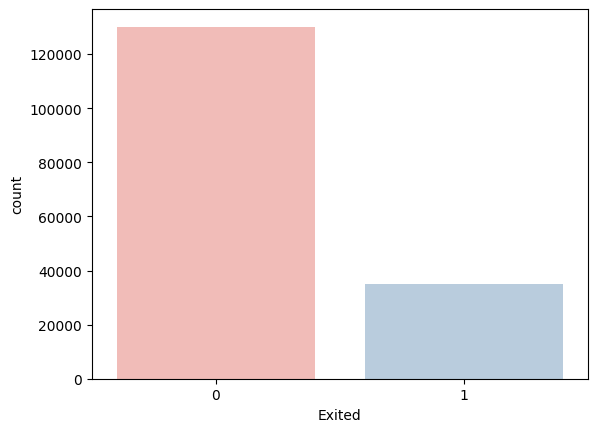

In [ ]:
sns.countplot( x = 'Exited', data = train, palette = 'Pastel1')

Imbalanced data

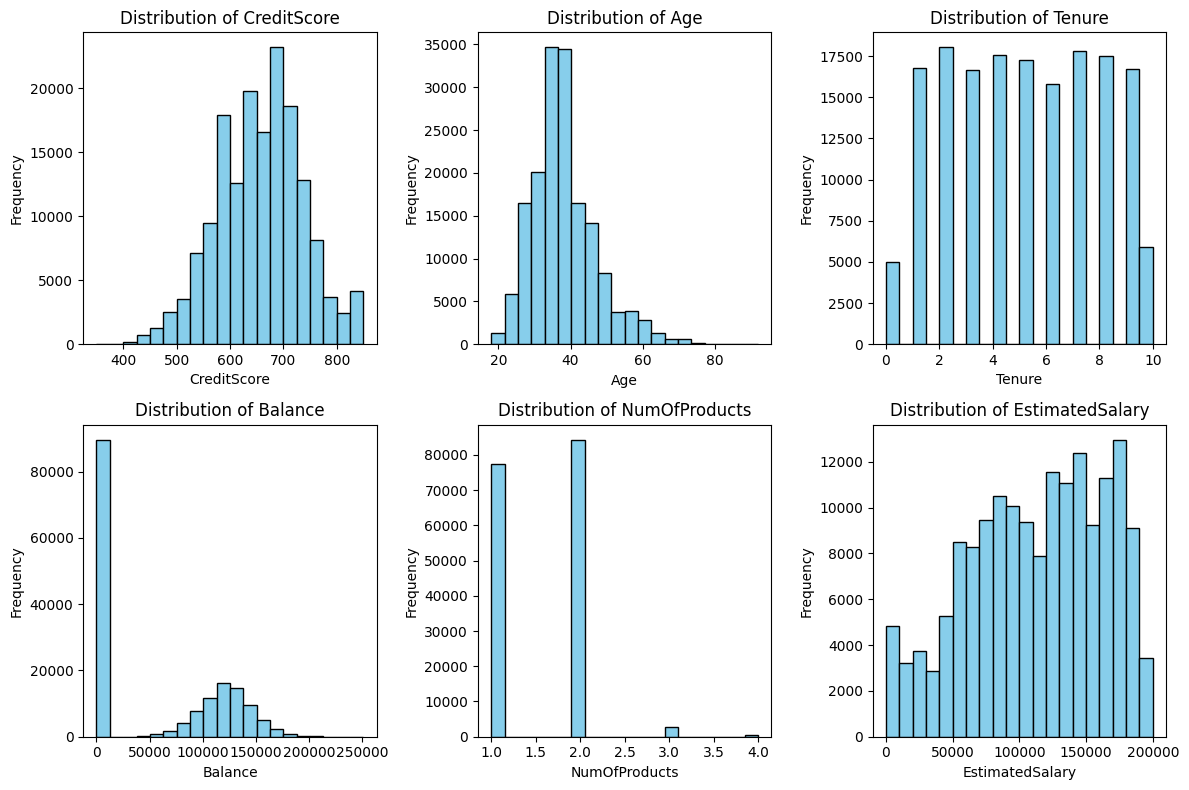

In [ ]:
#distribution of numerical value
numerical_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
plt.figure(figsize=(12, 8))
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 3, i)
    plt.hist(train[var], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

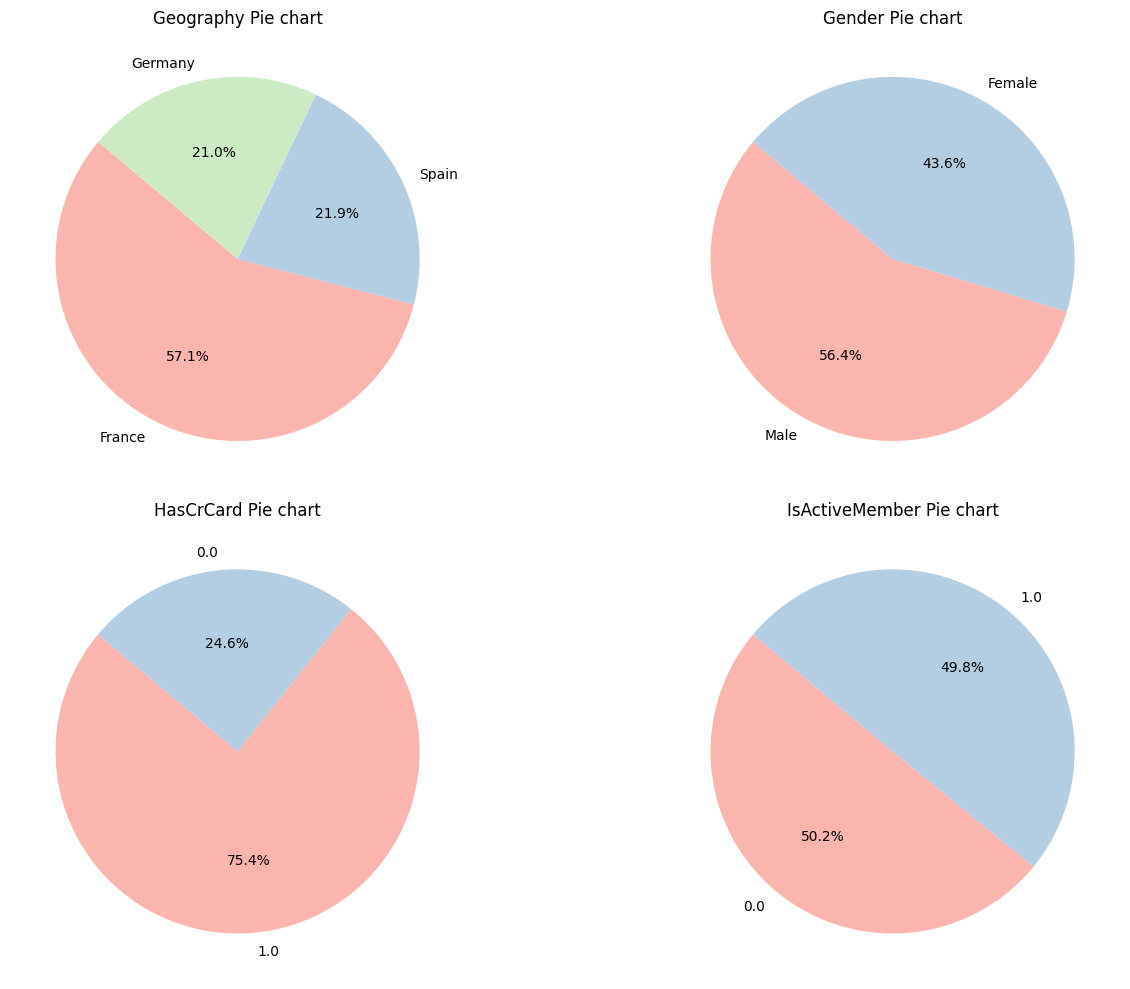

In [ ]:
# pie chart for categorical variables
categ_vals = ['Geography','Gender', 'HasCrCard', 'IsActiveMember']
plt.figure(figsize=(15, 10))
for i,var in enumerate(categ_vals, 1):
  plt.subplot(2,2,i)
  counts = train[var].value_counts()
  plt.pie(counts, labels = counts.index, autopct='%1.1f%%', startangle = 140, colors = sns.color_palette('Pastel1'))
  plt.title(f'{var} Pie chart')
plt.tight_layout()
plt.show()

<ipython-input-61-9510f0e67d85>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Exited', y = var, data = train, palette = 'Pastel1')
<ipython-input-61-9510f0e67d85>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Exited', y = var, data = train, palette = 'Pastel1')
<ipython-input-61-9510f0e67d85>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Exited', y = var, data = train, palette = 'Pastel1')
<ipython-input-61-9510f0e67d85>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in

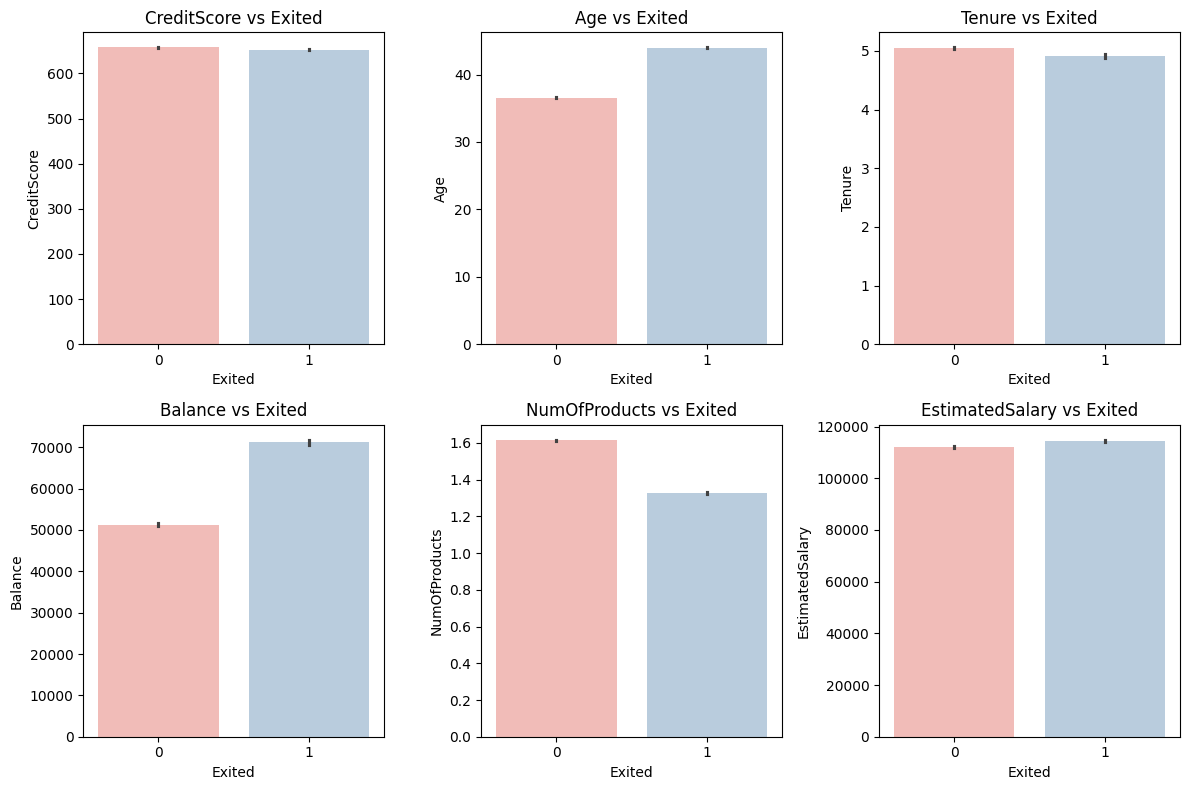

In [ ]:
#regardons quelles variables sont interessante pour notre étude
plt.figure(figsize = (12,8))
for i,var in enumerate(numerical_vars, 1):
  plt.subplot(2,3,i)
  sns.barplot(x = 'Exited', y = var, data = train, palette = 'Pastel1')
  plt.title(f'{var} vs Exited')
  plt.xlabel('Exited')
  plt.ylabel(var)
plt.tight_layout()
plt.show()

prepocessing

In [ ]:
num_cols = train.drop(['Geography','Gender', 'HasCrCard', 'IsActiveMember'] + ["id", "CustomerId", "Surname"] + ['Exited'], axis = 1)
cat_cols = train.drop(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] + ["id", "CustomerId", "Surname"] + ['Exited'], axis = 1)

In [ ]:
seed = 19

In [ ]:
#spleeting data

X_train,X_valid,y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.20)

In [ ]:

scale_pos_weight = train['Exited'].value_counts()[0] / train['Exited'].value_counts()[1]

In [ ]:
num_transformer = Pipeline(steps = [('num_imputer', SimpleImputer(strategy = 'median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps = [('cat_imputer', SimpleImputer(strategy = 'most_frequent')), ('encoder', TargetEncoder())])

feature_transformations = ColumnTransformer(transformers = [('num_transformations', num_transformer, numerical_vars), ('cat_transformations', cat_transformer, categ_vals)])

pipe =Pipeline(steps = [('feature_transformations' , feature_transformations), ('model', LGBMClassifier())])

params_grid = [{'feature_transformations' : [feature_transformations],
                'model' : [LGBMClassifier(verbosity =  1)],
                'model__n_estimators': [int(x) for x in np.linspace(75, 150, num=75)],
                'model__max_depth' : [int(x) for x in np.linspace(3, 12, num=9)],
                'model__learning_rate' : np.linspace(0.01, 0.5),
                'model__class_weight' : [None, 'balanced'],
                'model__random_state' : [seed],
                'model__importance_type' : ['gain']
                },
               {'feature_transformations': [feature_transformations],
                'model': [XGBClassifier(verbosity=0)],
                'model__n_estimators': [int(x) for x in np.linspace(75, 150, num=75)],
                'model__max_depth': [int(x) for x in np.linspace(3, 12, num=9)],
                'model__learning_rate': np.linspace(0.01, 0.5),
                'model__scale_pos_weight': [None, scale_pos_weight],
                'model__random_state': [seed],
                'model__importance_type': ['gain']}

               ]



In [ ]:
def custom_refit_criteria(cv_results_):
    cv_results_ = {key.replace("test", "validation") if "test" in key
                   else key: value for key, value in cv_results_.items()}

    return np.argmax(cv_results_['mean_validation_roc_auc'] - cv_results_['std_validation_roc_auc'])

In [ ]:
evaluation_metrics = {'accuracy' : 'accuracy',
                      'precision' : 'precision',
                      'recall' : 'recall',
                      'f1_score' : 'f1',
                      'avg_precision' : 'average_precision',
                      'roc_auc' : 'roc_auc'}

cross_validator = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)

best_model_pipe = RandomizedSearchCV(estimator = pipe,
                                     param_distributions = params_grid,
                                     n_iter = 300,
                                     cv = cross_validator,
                                     scoring = evaluation_metrics,
                                     refit = custom_refit_criteria,
                                     error_score = 'raise',
                                     return_train_score = False,
                                     random_state = seed,
                                     verbose = 1)


best_model_pipe.fit(X_train, y_train)

print(f"\n-> Best Pipeline found in RandomSearchCV hyperparameter optimizer:\n {best_model_pipe.best_estimator_}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't expl

In [ ]:
best_model_pipe.cv_results_ = {key.replace("test", "validation") if "test" in key
                               else key: value for key, value in best_model_pipe.cv_results_.items()}

# Visualizing all results and metrics, from all models, obtained by the RandomSearchCV steps
df_results = pd.DataFrame(best_model_pipe.cv_results_)

display(df_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__scale_pos_weight,param_model__random_state,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__importance_type,...,std_validation_avg_precision,rank_validation_avg_precision,split0_validation_roc_auc,split1_validation_roc_auc,split2_validation_roc_auc,split3_validation_roc_auc,split4_validation_roc_auc,mean_validation_roc_auc,std_validation_roc_auc,rank_validation_roc_auc
0,1.740169,0.626774,0.219912,0.007244,3.725924,19,88,5,0.12,gain,...,0.003408,32,0.886142,0.887698,0.889740,0.888318,0.887722,0.887924,0.001159,30
1,2.801828,0.429545,0.455997,0.125550,None,19,116,10,0.24,gain,...,0.002699,271,0.873207,0.873240,0.873685,0.875487,0.871874,0.873499,0.001165,271
2,2.362106,0.910521,0.455749,0.059124,NaN,19,145,3,0.09,gain,...,0.003346,82,0.885290,0.887069,0.889724,0.887778,0.887182,0.887408,0.001425,72
3,1.911260,0.215566,0.504219,0.065514,NaN,19,113,5,0.27,gain,...,0.002382,87,0.884818,0.886787,0.888462,0.887828,0.886916,0.886962,0.001235,96
4,2.638687,0.673381,0.360383,0.009110,3.725924,19,144,8,0.32,gain,...,0.001210,276,0.870447,0.868764,0.870709,0.870812,0.867500,0.869646,0.001305,277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2.075633,0.517378,0.249577,0.046140,None,19,112,4,0.14,gain,...,0.003297,10,0.886196,0.887942,0.890074,0.888405,0.887687,0.888061,0.001249,8
296,2.098003,0.146785,0.522076,0.067179,NaN,19,131,4,0.3,gain,...,0.003341,88,0.885289,0.886832,0.889487,0.887858,0.886160,0.887125,0.001449,88
297,2.367370,0.201705,0.716703,0.086247,NaN,19,135,6,0.1,gain,...,0.002952,26,0.885692,0.887892,0.889759,0.888632,0.887384,0.887872,0.001351,37
298,1.868147,0.248142,0.417362,0.010411,NaN,19,98,12,0.36,gain,...,0.003475,197,0.881627,0.884570,0.884490,0.883970,0.882930,0.883517,0.001111,193


In [ ]:
df_results[df_results.index == best_model_pipe.best_index_]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__scale_pos_weight,param_model__random_state,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__importance_type,...,std_validation_avg_precision,rank_validation_avg_precision,split0_validation_roc_auc,split1_validation_roc_auc,split2_validation_roc_auc,split3_validation_roc_auc,split4_validation_roc_auc,mean_validation_roc_auc,std_validation_roc_auc,rank_validation_roc_auc
223,1.405338,0.097345,0.261323,0.082836,None,19,79,5,0.19,gain,...,0.003178,7,0.886343,0.887777,0.889542,0.888583,0.887597,0.887968,0.001065,21


In [ ]:
df_results[df_results.index == best_model_pipe.best_index_][['mean_validation_roc_auc',
                                                             'std_validation_roc_auc']]

,mean_validation_roc_auc,std_validation_roc_auc
223,0.887968,0.001065


In [ ]:
df_results[df_results.index == best_model_pipe.best_index_][['mean_validation_precision',
                                                             'std_validation_precision']]

,mean_validation_precision,std_validation_precision
223,0.738619,0.003835


In [ ]:
test_predictions = best_model_pipe.predict(X_valid)
test_predicted_probabilities = best_model_pipe.predict_proba(X_valid)[:, 1]

test_metrics_dict = {'test_accuracy': accuracy_score(y_valid, test_predictions),
                     'test_precision': precision_score(y_valid, test_predictions),
                     'test_recall': recall_score(y_valid, test_predictions),
                     'test_f1_score': f1_score(y_valid, test_predictions),
                     'test_avg_precision': average_precision_score(y_valid, test_predicted_probabilities),
                     'test_roc_auc': roc_auc_score(y_valid, test_predicted_probabilities)}

print(f"-> Best model's evaluation metrics, hold-out test set:\n {test_metrics_dict}")

-> Best model's evaluation metrics, hold-out test set:
 {'test_accuracy': 0.862695791801739, 'test_precision': 0.7334068762640191, 'test_recall': 0.5641352001131382, 'test_f1_score': 0.6377298161470822, 'test_avg_precision': 0.7288245664769666, 'test_roc_auc': 0.8872428223393097}


In [ ]:
df_submission = pd.read_csv("test.csv")

df_submission['Exited'] = best_model_pipe.predict_proba(df_submission.drop(["id", "CustomerId", "Surname"] , axis=1))[:, 1]

df_submission

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,0.027224
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,0.810951
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,0.025989
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,0.218932
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,0.330606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62,0.040416
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68,0.117805
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38,0.019389
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58,0.150190


In [ ]:
df_submission[['id', 'Exited']].to_csv('submission.csv', index=False)